## Sentence Classification with CNN

1) 원래 코드에 주석 달기

2) 새로운 데이터셋 적용하여 돌려보기

3) 구현 시 주의해야할 사항 미리 생각해오기

### initial settings

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np

SEED = 4321
BATCH_SIZE = 64
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 1
DROPOUT = 0.8
VOCAB_SIZE = 15000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### simple utilities for implementations

In [2]:
import codecs
import re
import time
import random

def simple_reader(path):
    corpus = list()
    reader = codecs.open(path, 'r', encoding='utf-8')
    for line in reader:
        corpus.append(line.strip())
    reader.close()
    return corpus

def simple_writer(path, target):
    random.shuffle(target)
    writer = codecs.open(path, 'w', encoding='utf-8')
    for line in target:
        writer.write(line.strip() + '\n')
    writer.close()

def clean_str(string, TREC=False):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Every dataset is lower cased except for TREC
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'`]", " ", string)
    string = re.sub(r"\'(s|ve|re|d|ll)", r" \'\1", string)
    string = re.sub(r"n\'t", r" n\'t", string)
    string = re.sub(r"([,!)(?]|\s{2,})", r" \1 ", string)
    return string.strip() if TREC else string.strip().lower()


def clean_str_sst(string):
    """
    Tokenization/string cleaning for the SST dataset
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'`]", " ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

def clean_list(corpus):
    new_corpus = list()
    for line in corpus:
        if '\t' in line:
            label, single_line = line.strip().split('\t')
            single_line = clean_str(single_line)
            if single_line.strip() == '':
                continue
            new_line = '\t'.join([label, single_line])
            new_corpus.append(new_line)
    return new_corpus

### Load dataset and preprocessing

In [3]:
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vocab

# define fields
TEXT = data.Field(sequential=True, use_vocab=True, tokenize=lambda x: x.split(' '), lower=False, batch_first=True, fix_length=20)
LABEL = data.Field(sequential=False, unk_token=None)

# preprocessing corpus
datalist = simple_reader('/home/suin/study/cnn/dataset/rt-polarity.pos') + simple_reader('/home/suin/study/cnn/dataset/rt-polarity.neg')
datalist = clean_list(datalist)
simple_writer('/home/suin/study/cnn/dataset/rt-polarity_clean.txt', datalist)

# load dataset with torchtext TabularDataset
dataset = data.TabularDataset(path='/home/suin/study/cnn/dataset/rt-polarity_clean.txt', 
                              fields=[('label', LABEL), ('text', TEXT)], format='csv', 
                              csv_reader_params={'delimiter': '\t'}, skip_header=True)

### Load Word2Vec (GoogleNews 300 dim version)

In [4]:
from gensim.models import KeyedVectors

word2vec = KeyedVectors.load_word2vec_format("/home/suin/study/cnn/cnn/GoogleNews-vectors-negative300.bin", binary=True)
word2index = {token: token_index for token_index, token in enumerate(word2vec.index2word)}

In [5]:
# divide dataset as 8 : 2 : 1

train_data, test_data = dataset.split(split_ratio=0.9, random_state = random.seed(SEED))
train_data, valid_data = train_data.split(split_ratio=7./9, random_state = random.seed(SEED))

TEXT.build_vocab(train_data, max_size = VOCAB_SIZE)
LABEL.build_vocab(train_data)
TEXT.vocab.set_vectors(word2index, torch.from_numpy(word2vec.vectors).float().to(device), word2vec.vector_size)

train_iterator = data.Iterator(train_data, batch_size=BATCH_SIZE, train=True, device=device, sort_key=lambda x: len(x.text), sort_within_batch=False)
valid_iterator = data.Iterator(valid_data, batch_size=BATCH_SIZE, train=False, device=device, sort_key=lambda x: len(x.text), sort_within_batch=False)
test_iterator = data.Iterator(test_data, batch_size=BATCH_SIZE, train=False, device=device, sort_key=lambda x: len(x.text), sort_within_batch=False)

print('number of training data : {}'.format(len(train_data)))
print('number of valid data : {}'.format(len(valid_data)))
print('number of test data : {}'.format(len(test_data)))

number of training data : 7463
number of valid data : 2132
number of test data : 1066


### Model training and evaluating functions

In [6]:
class CNN1d(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout, pad_idx):        
        super().__init__()        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = embedding_dim, 
                                              out_channels = n_filters, 
                                              kernel_size = fs)
                                    for fs in filter_sizes
                                    ])        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)        
        self.dropout = nn.Dropout(dropout)        
    def forward(self, text):        
        #text = [batch size, sent len]        
        embedded = self.embedding(text)                
        #embedded = [batch size, sent len, emb dim]        
        embedded = embedded.permute(0, 2, 1)        
        #embedded = [batch size, emb dim, sent len]        
        conved = [F.relu(conv(embedded)) for conv in self.convs]            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]        
        #pooled_n = [batch size, n_filters]        
        cat = self.dropout(torch.cat(pooled, dim = 1))        
        #cat = [batch size, n_filters * len(filter_sizes)]            
        return self.fc(cat)

def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

def train(model, iterator, optimizer, criterion):    
    epoch_loss = 0
    epoch_acc = 0    
    model.train()    
    for batch in iterator:
        # print(batch.text)
        optimizer.zero_grad()        
        predictions = model(batch.text).squeeze(1)        
        loss = criterion(predictions, batch.label.float())        
        acc = binary_accuracy(predictions, batch.label)        
        loss.backward()
        optimizer.step()        
        epoch_loss += loss.item()
        epoch_acc += acc.item()        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):    
    epoch_loss = 0
    epoch_acc = 0    
    model.eval()    
    with torch.no_grad():    
        for batch in iterator:
            predictions = model(batch.text).squeeze(1)            
            loss = criterion(predictions, batch.label.float())            
            acc = binary_accuracy(predictions, batch.label.float())
            epoch_loss += loss.item()
            epoch_acc += acc.item()        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Model parameter setting

In [7]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

# Initialize a model here...
model = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data.copy_(TEXT.vocab.vectors)

optimizer = optim.Adadelta(model.parameters(), lr=0.3)
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

### train and test the model

In [8]:
N_EPOCHS = 10
best_valid_loss = float('inf')
best_test_loss = float('inf')
train_losses = list()
valid_losses = list()
train_acces = list()
valid_acces = list()

for epoch in range(N_EPOCHS):
    # Train the model here...a
    start_time = time.time() 
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_acces.append(train_acc)
    valid_acces.append(valid_acc)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/home/suin/study/cnn/cnn/model/tut4-model.pt')    
    # Create prediction for val_dataset and get a score...
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    
# Create inference for test_dataset...
test_loss, test_acc = evaluate(model, test_iterator, criterion)  
print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
print(f'\t Test Loss: {test_loss:.3f} |  Val. Acc: {test_acc*100:.2f}%')
    

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.679 | Train Acc: 56.98%
	 Val. Loss: 0.659 |  Val. Acc: 65.66%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.632 | Train Acc: 66.74%
	 Val. Loss: 0.596 |  Val. Acc: 72.54%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.576 | Train Acc: 70.88%
	 Val. Loss: 0.570 |  Val. Acc: 70.39%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.534 | Train Acc: 74.41%
	 Val. Loss: 0.526 |  Val. Acc: 74.01%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.505 | Train Acc: 75.90%
	 Val. Loss: 0.512 |  Val. Acc: 74.83%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.478 | Train Acc: 77.94%
	 Val. Loss: 0.510 |  Val. Acc: 74.72%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.454 | Train Acc: 79.70%
	 Val. Loss: 0.502 |  Val. Acc: 75.10%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.432 | Train Acc: 80.67%
	 Val. Loss: 0.502 |  Val. Acc: 75.01%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.408 | Train Acc: 81.69%
	 Val. Loss: 0.493 |  Val. Acc: 75.74%
Epoch: 10 | Epoch Time: 0m 0

### draw graph about losses and accuracies

In [9]:
import matplotlib.pyplot as plt

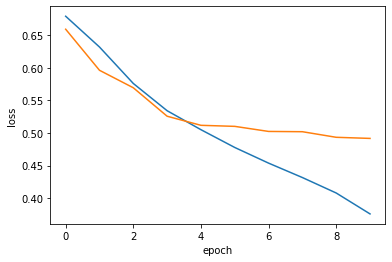

In [10]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
plt.plot(train_acces)
plt.plot(valid_acces)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()